# Tutorial: Sleep Analysis

**Author:** Masoud Abedinifar

**Last update:** Wednesday 11 December 2024

## Learning Objectives
By the end of this tutorial:

- Apply the `Sleep Analysis` algorithm.
- Visualize the results of the algorithm.
- Interpret results.


# Sleep Analysis

This example can be referenced by citing the package.

This algorithm implements a sleep analysis system to detect nocturnal rest, classify postures,
detect turns, and evaluate rest efficiency using accelerometer data collected from an inertial
measurement unit (IMU) sensor.

The core of the algorithm lies in the `detect` method, where accelerometer data is processed to 
identify periods of nocturnal rest, classify body postures, and detect turning events. The process 
begins with the smoothing of accelerometer signals to reduce noise, followed by the detection of 
periods of lying based on vertical acceleration thresholds. These periods are further refined by 
removing short bouts that do not meet a minimum duration criterion.

Posture classification is performed using the orientation angle (theta), calculated from the 
accelerometer's mediolateral, anterior-posterior, and vertical components. The algorithm divides 
postures into four categories: back, right side, left side, and belly. Turns are detected by 
identifying transitions between these classified postures.

Detected turns are characterized by their onset times and durations. The algorithm 
uses a turn angle threshold to filter out minor movements, ensuring that only significant turns are 
included in the analysis. The results are stored in a pandas DataFrame (`posture_` attribute) 
in BIDS-like format, containing details such as the onset, duration, and type of each detected event.

Optionally, if `plot_results` is set to True, the algorithm generates a detailed visualization of the 
analysis results. This includes plots of vertical acceleration, detected nocturnal rest, posture 
classifications, and detected turns, offering insights into the dynamics of the analyzed data.

#### References
[`1`] Louter et al. (2015). Accelerometer-based quantitative analysis of axial nocturnal movements ...

[`2`] Mirelman et al. (2020). Tossing and Turning in Bed: Nocturnal Movements in Parkinson's Disease ...~

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and SleepAnalysis algortihm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `kielmat` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kielmat.modules.sa import SleepAnalysis
from pathlib import Path
import scipy.io
from typing import Tuple
from datetime import datetime, timedelta
import matplotlib.dates as mdates


## Data Preparation

To implement Sleep Analysis algorithm, we load example data from Braviva project.


In [2]:
# Import data from Braviva project
def import_bravia_data(file_path: str, body_location: str, sensor_type: str = "accel") -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Imports data from a MATLAB .mat file of Bravia project and formats it into standardized `data` and `channels` DataFrames.

    Args:
        file_path (str): Path to the .mat file.
        body_location (str): Body location to filter the desired sensor data.
        sensor_type (str): Type of sensor to import (default is 'accel').

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: 
            - `data`: DataFrame containing the sensor data.
            - `channels`: DataFrame containing metadata about the channels.

    Example:
        >>> file_path = r"path/to/matfile.mat"
        >>> body_location = "SA"  # Lower back
        >>> data, channels = import_matlab_data(file_path, body_location)
    """
    # Load the MATLAB data file
    mat_data = scipy.io.loadmat(file_path)

    # Access the main data
    data = mat_data['data']

    # Initialize variables for accelerometer data and sampling frequency
    accel_data = None
    sampling_frequency = None
    accel_columns = []

    # Iterate over all the data entries to find the target body location and sensor type
    for entry in data[0]:
        if entry['bodyLocation'][0] == body_location:  # Match the desired body location
            for sensor in entry['sensorData'][0]:
                if sensor[0][0] == sensor_type:  # Match the sensor type
                    # Extract sampling frequency
                    sampling_frequency = sensor[2][0][0]

                    # Extract accelerometer data
                    accel_data = sensor[3]

                    # Extract the units of the accelerometer
                    accel_unit = sensor[5][0][:].strip()

                    # Define column names for the accelerometer data
                    accel_columns = [f"{body_location}_ACCEL_{axis}" for axis in ["x", "y", "z"]]

    if accel_data is None or not accel_columns:
        raise ValueError(f"No sensor data found for body location '{body_location}' and sensor type '{sensor_type}'.")

    # Create the `data` DataFrame
    data_df = pd.DataFrame(accel_data, columns=accel_columns)

    # Create the `channels` DataFrame
    channels_dict = {
        "name": accel_columns,
        "component": ["x", "y", "z"],
        "type": ["ACCEL"] * 3,
        "tracked_point": [body_location] * 3,
        "units": [accel_unit] * 3,
        "sampling_frequency": [sampling_frequency] * 3,
    }
    channels_df = pd.DataFrame(channels_dict)

    return data_df, channels_df

# Load data using the provided importer
file_path = r'\Sleep Analysis\sample_data\20190801_T1_COKI10147.mat'

# Define the lowerback as tracking point which is name as "SA" in this dataset
body_location = "SA"  # Lower back

# Load the data and channels
data, channels = import_bravia_data(file_path, body_location)

# Load lower back acceleration data
accel_df = data
print(f"Acceleration data:", accel_df)

# Extract acceleration unit from channels
accel_unit = channels["units"].iloc[0]  # Assuming all rows in `channels` have the same unit
print(f"Unit of acceleration data is:", accel_unit)

# Get the sampling frequency
sampling_frequency = channels["sampling_frequency"].iloc[0]
print(f"Acceleration data was sampled at:", sampling_frequency, f"Hz")

# Define the start timestamp based on data to have real time on the axis
start_time = datetime.strptime("01-Aug-2019 20:30:00", "%d-%b-%Y %H:%M:%S")

# Calculate the time interval between consecutive samples
time_interval = 1 / sampling_frequency

# Generate timestamps based on the number of rows in the data
dt_data = [start_time + timedelta(seconds=i * time_interval) for i in range(len(accel_df))]

# Convert dt_data to a pandas Series
dt_data = pd.Series(dt_data, name="timestamp")

Acceleration data:          SA_ACCEL_x  SA_ACCEL_y  SA_ACCEL_z
0          0.024977   -0.025972    1.005035
1          0.026929   -0.023278    1.002859
2          0.025953   -0.024258    1.004068
3          0.026441   -0.021319    1.005761
4          0.026197   -0.026707    1.003826
...             ...         ...         ...
5299228    0.985826    0.015416   -0.141558
5299229    0.985338    0.018600   -0.141800
5299230    0.983874    0.017620   -0.144459
5299231    0.985582    0.015416   -0.144459
5299232    0.986314    0.016396   -0.141316

[5299233 rows x 3 columns]
Unit of acceleration data is: g
Acceleration data was sampled at: 128 Hz


## Visualisation of the Data
The raw acceleration data including components of x, y and z axis are plotted.

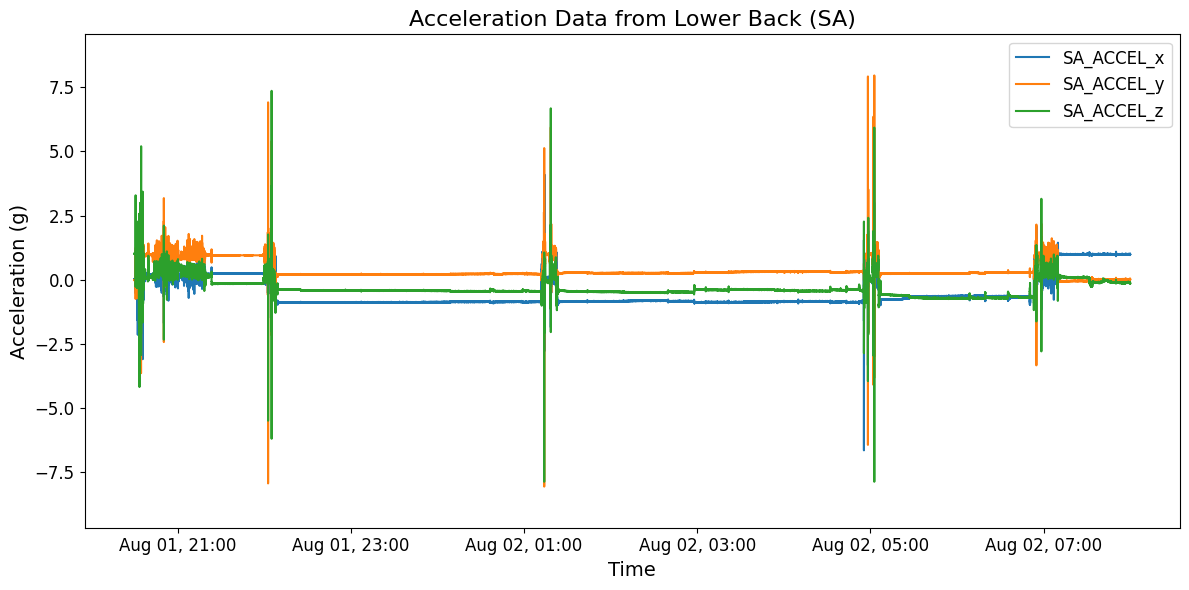

In [3]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Use time in real datetime format
time = dt_data

# Plot each acceleration component
for col in accel_df.columns:
    ax.plot(
        time, 
        accel_df[col], 
        label=col,
    )

# Set plot labels and legend
ax.set_ylabel("Acceleration (g)", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
ax.legend(loc="upper right", fontsize=12)

# Adjust the y-axis limits
accel_min = accel_df.min().min()
accel_max = accel_df.max().max()
buffer = (accel_max - accel_min) * 0.1
ax.set_ylim(accel_min - buffer, accel_max + buffer)

# Set title
ax.set_title("Acceleration Data from Lower Back (SA)", fontsize=16)

# Format the x-axis to show hours and dates
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %H:%M"))  
plt.setp(ax.get_xticklabels(), fontsize=12)  
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


#### Data Units and Conversion to SI Units

All input data provided to the modules in this toolbox should adhere to SI units to maintain consistency and accuracy across analyses. This ensures compatibility with the underlying algorithms, which are designed to work with standard metric measurements.

If any data is provided in non-SI units (e.g., acceleration in g instead of m/s²), it is needed that the data to be converted into the appropriate SI units before using it as input to the toolbox. Failure to convert non-SI units may lead to incorrect results or misinterpretation of the output.

For instance:

- **Acceleration:** Convert from g to m/s².

In [4]:
# Check unit of acceleration data
if accel_unit in ["m/s^2"]:
    pass  # No conversion needed
elif accel_unit in ["g", "G"]:
    # Convert acceleration data from "g" to "m/s^2"
    accel_df *= 9.81
    # Update unit of acceleration
    accel_unit = ["m/s^2"]

## Applying Sleep Analysis Algorithm

In order to apply Sleep Analysis algorithm, an instance of the SleepAnalysis class is created using the constructor, `SleepAnalysis()`. The `sleep_analyzer` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Acceleration data:** `accel_data` (pd.DataFrame) includes accelerometer data (N, 3) for x, y, and z axes. in pandas Dataframe format. The unit of acceleration data should be in SI as m/s².
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Vertical Acceleration:** `v_accel_col_name` is the column name corresponding to the vertical acceleration.
- **Tracking system:** `tracking_system` is the name of tracking system which is optional.
- **Tracked Point:** `tracked_point` is the tracked point name on the body which is optional.
- **Timestamps:** `dt_data` is the real timestamps of acceleration data corresponding to each sample.
- **Plot Results:** `plot_results`, if set to True, generates a plot showing the results.

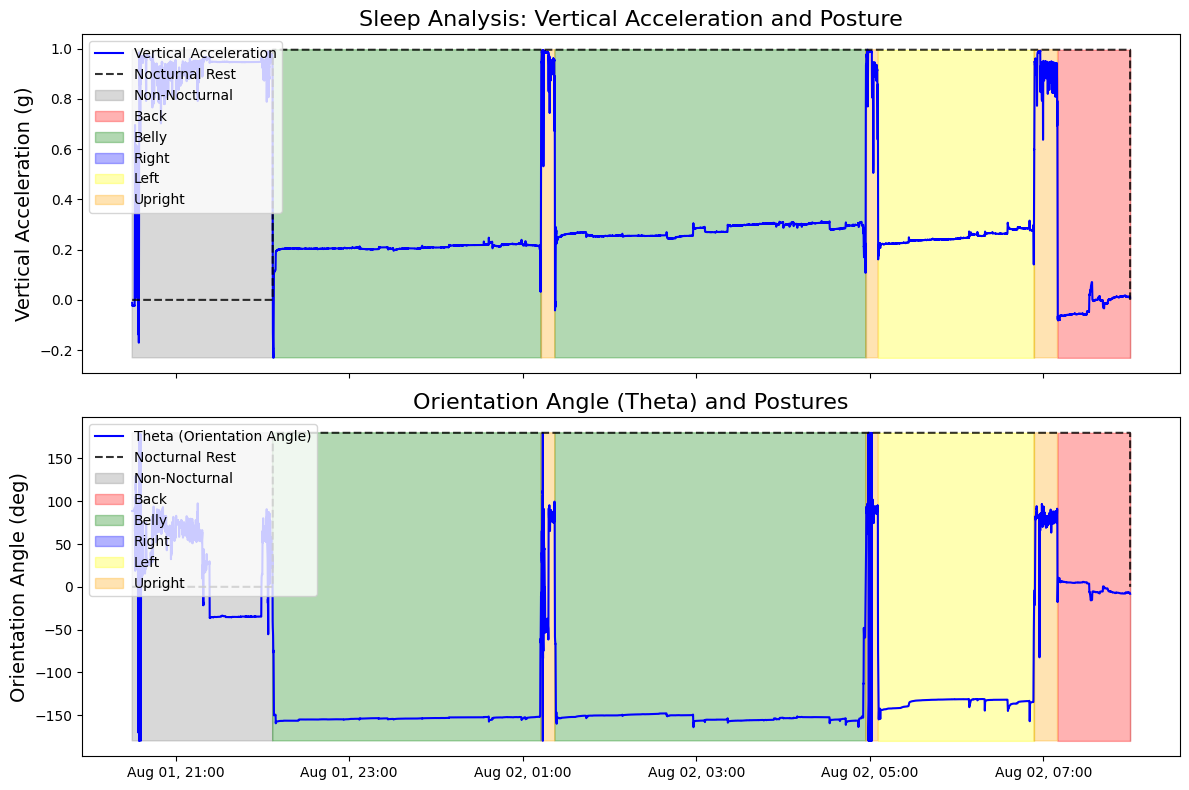

In [5]:
# Initialize the SleepAnalysis instance
sleep_analyzer = SleepAnalysis()

# Run detection and visualize results
sleep_analyzer.detect(
    accel_data=accel_df,
    v_accel_col_name="SA_ACCEL_y",
    sampling_frequency=int(sampling_frequency),
    tracking_system="imu",
    tracked_point="SA",
    dt_data=dt_data,
    plot_results=True
)

The outputs are stored in the `posture_` attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the posture event in seconds.
- **duration**: Duration of the posture event in seconds.
- **event_type**: Type of event.
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'SA' for this example.

In [6]:
# Display the results
print("\nSleep Analysis Results:")
print(sleep_analyzer.posture_)


Sleep Analysis Results:
                       onset      duration     event_type tracking_system  \
0 2019-08-01 20:30:00.000000   5829.000000  Non-Nocturnal             imu   
1 2019-08-01 22:07:09.000000  11131.492188          Belly             imu   
2 2019-08-02 01:12:40.492188    575.007812        Upright             imu   
3 2019-08-02 01:22:15.500000  12895.492188          Belly             imu   
4 2019-08-02 04:57:10.992188    513.007812        Upright             imu   
5 2019-08-02 05:05:44.000000   6468.992188           Left             imu   
6 2019-08-02 06:53:32.992188    974.007812        Upright             imu   
7 2019-08-02 07:09:47.000000   3013.250000           Back             imu   

  tracked_point  
0            SA  
1            SA  
2            SA  
3            SA  
4            SA  
5            SA  
6            SA  
7            SA  
